In [1]:
#!pip install h5py

In [2]:
import project_code

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.optimize import curve_fit

In [4]:
import h5py
import os

train_path = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Train_2.hdf5"
test_path  = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Test_2.hdf5"  # change if needed

def list_keys(path, label):
    try:
        with h5py.File(path, "r") as f:
            filename = os.path.basename(path)
            print(f"\n=== {label.upper()} FILE: {filename} ===")
            first_key = list(f.keys())[0]
            print("Number of rows:", f[first_key].shape[0])
            print("Columns (datasets):")
            for k in f.keys():
                print("  ", k)
    except Exception as e:
        print(f"{label.capitalize()} file not found or error reading it:", e)

list_keys(train_path, "train")
list_keys(test_path, "test")


Train file not found or error reading it: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\YooNi\OneDrive\Desktop\DSC180A\MJD_Train_2.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Test file not found or error reading it: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\YooNi\OneDrive\Desktop\DSC180A\MJD_Test_2.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [5]:
# file_path = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Train_2.hdf5"
file_path = "/Users/nomin1/Desktop/capstone/MJD_Train_0.hdf5"

In [6]:
#loads in waveform & data, then chooses random datapoint
with h5py.File(file_path, 'r') as file:
    #load waveform & time index
    raw_waveform = np.array(file["raw_waveform"])
    time_index = np.arange(0,raw_waveform.shape[1])

    #load labels
    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    id = np.array(file["id"])
    
    #choose random datapoint
    random_index = np.random.choice(id.shape[0])

    #get datapoint waveform & labels
    random_waveform = raw_waveform[random_index]
    energy_value = energy_label[random_index]
    psd_low_avse_value = psd_label_low_avse[random_index]
    psd_high_avse_value = psd_label_high_avse[random_index]
    psd_dcr_value = psd_label_dcr[random_index]
    psd_lq_value = psd_label_lq[random_index]
    tp0_value = tp0[random_index]
    detector_value = detector[random_index]
    run_number_value = run_number[random_index]
    id_value = id[random_index]

Data Labels:
Energy: 2277.877065692097
PSD Low Avse: True
PSD High Avse: True
PSD DCR: True
PSD LQ: True
TP0: 978
Detector: 172
Run Number: 52673
ID: 57333


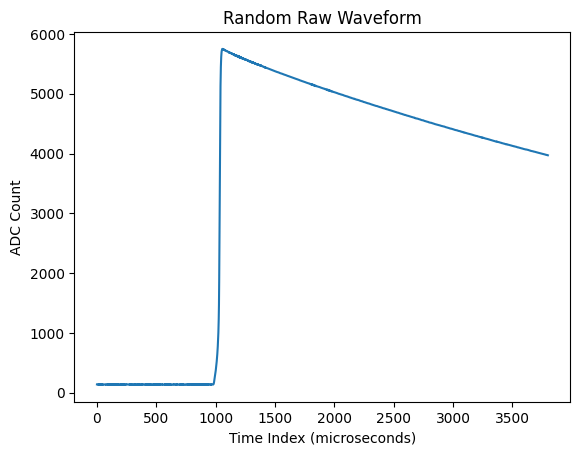

In [7]:
fig, ax = plt.subplots()
ax.plot(time_index, random_waveform)
ax.set_title("Random Raw Waveform")
ax.set_xlabel("Time Index (microseconds)")
ax.set_ylabel("ADC Count")

print("Data Labels:")
print(f"Energy: {energy_value}")
print(f"PSD Low Avse: {psd_low_avse_value}")
print(f"PSD High Avse: {psd_high_avse_value}")
print(f"PSD DCR: {psd_dcr_value}")
print(f"PSD LQ: {psd_lq_value}")
print(f"TP0: {tp0_value}")
print(f"Detector: {detector_value}")
print(f"Run Number: {run_number_value}")
print(f"ID: {id_value}")

In [8]:
waveform = random_waveform

In [9]:
#Fsind tp0

#method 1: basic threshold
def find_baseline(waveform):
    #determines baseline from first 100 microseconds of waveform
    return sum(waveform[:100]) / 100

def find_tp0_method1(waveform, threshold):
    tp0 = np.argwhere(waveform > (find_baseline(waveform) + threshold))[0][0]
    return tp0

tp0_method1 = find_tp0_method1(waveform, 30)
tp0_method1


986

In [10]:
#method 2: slope
def find_tp0_method2(waveform, slope_threshold):
    waveform_gradient = np.gradient(waveform)
    waveform_gradient_baseline = find_baseline(waveform_gradient)
    waveform_gradient_threshold = waveform_gradient_baseline + slope_threshold
    return find_tp0_method1(waveform_gradient, waveform_gradient_threshold)
tp0_method2 = find_tp0_method2(waveform, 12)
tp0_method2


987

In [11]:
#method 3: gradient start of peak
waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)

peaks, _ = find_peaks(smoothed_waveform_gradient, height=max(smoothed_waveform_gradient/2))
widths, height_levels, left_ips, right_ips = peak_widths(smoothed_waveform_gradient, peaks, rel_height=0.95)

tp0_method3 = int(left_ips[0])
tp0_method3

989

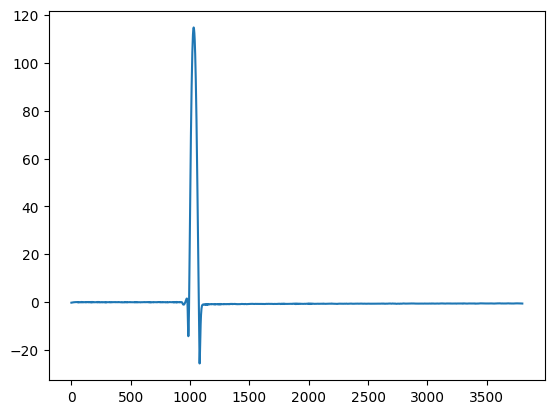

In [12]:
waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)
fig, ax = plt.subplots()
ax.plot(time_index, smoothed_waveform_gradient)

In [13]:
print(f"Basic threshold tp0: {tp0_method1}")
print(f"Slope threshold tp0: {tp0_method2}")
print(f"Gradient peak start tp0: {tp0_method3}")
print(f"Ground truth tp0: {tp0_value}")

Basic threshold tp0: 986
Slope threshold tp0: 987
Gradient peak start tp0: 989
Ground truth tp0: 978


In [14]:
# calculate tdrift, tdrift50, tdrift10 using method 3 tp0
estimated_tp0 = tp0_method3
tdrift, tdrift50, tdrift10 = project_code.calculate_drift_times(waveform, estimated_tp0)

In [15]:
print(f"tdrift: {tdrift}")
print(f"tdrift50: {tdrift50}")
print(f"tdrift10: {tdrift10}")

tdrift: 660
tdrift50: 438
tdrift10: 223


In [16]:
#pole zero correction
waveform_pz, waveform_tail_corrected = project_code.pole_zero_correction(waveform)

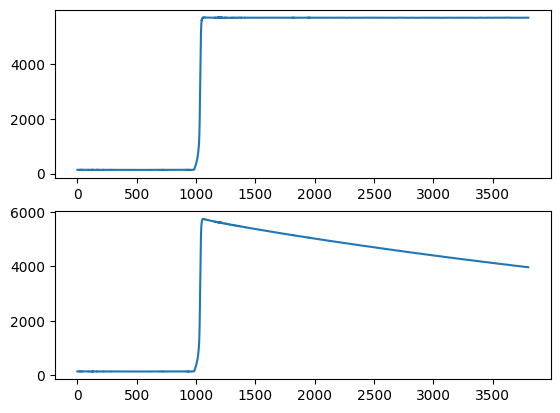

In [17]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(time_index, waveform_pz)
ax[1].plot(time_index, waveform)

In [18]:
#find lq80
lq80_region = project_code.calculate_lq80(waveform, waveform_tail_corrected)
lq80_region

2963.3358732935303

In [19]:
AvsE, A, E, slopes, wnorm_smooth = project_code.extract_avse(waveform, energy_value)
print(f"Extracted AvsE: {AvsE:5f}, A (current amplitude): {A:5f}, E (Energy): {E:5f}")

Extracted AvsE: 0.000004, A (current amplitude): 0.008320, E (Energy): 2277.877066


In [20]:
peak_idx = np.argmax(waveform)
tail_charge_diff = project_code.calculate_tail_charge_diff(waveform, energy_value, peak_idx)
print(f"Tail Charge Difference: {tail_charge_diff:5f}")

Tail Charge Difference: -0.109896


In [21]:
tfr = project_code.compute_tfr(waveform, waveform_pz, peak_idx)
print(f"Computed TFR: {tfr:5f}")

Computed TFR: 82.736400


In [22]:
g, stats = project_code.gradient_trace(waveform)
print(f"Gradient Stats: {stats}")

Gradient Stats: {'max_grad': 391.0, 'rms_grad': 17.95485259197375, 'grad_spread': 3.0}


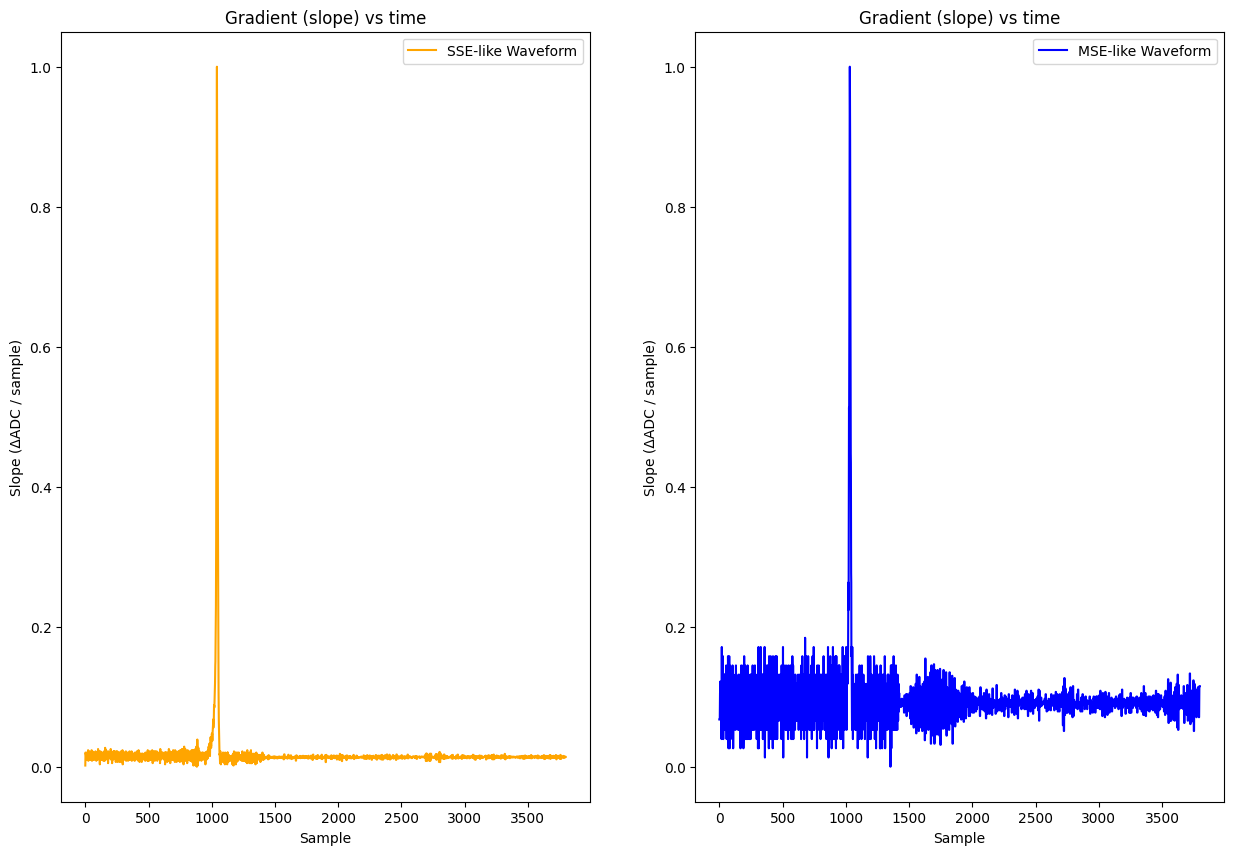

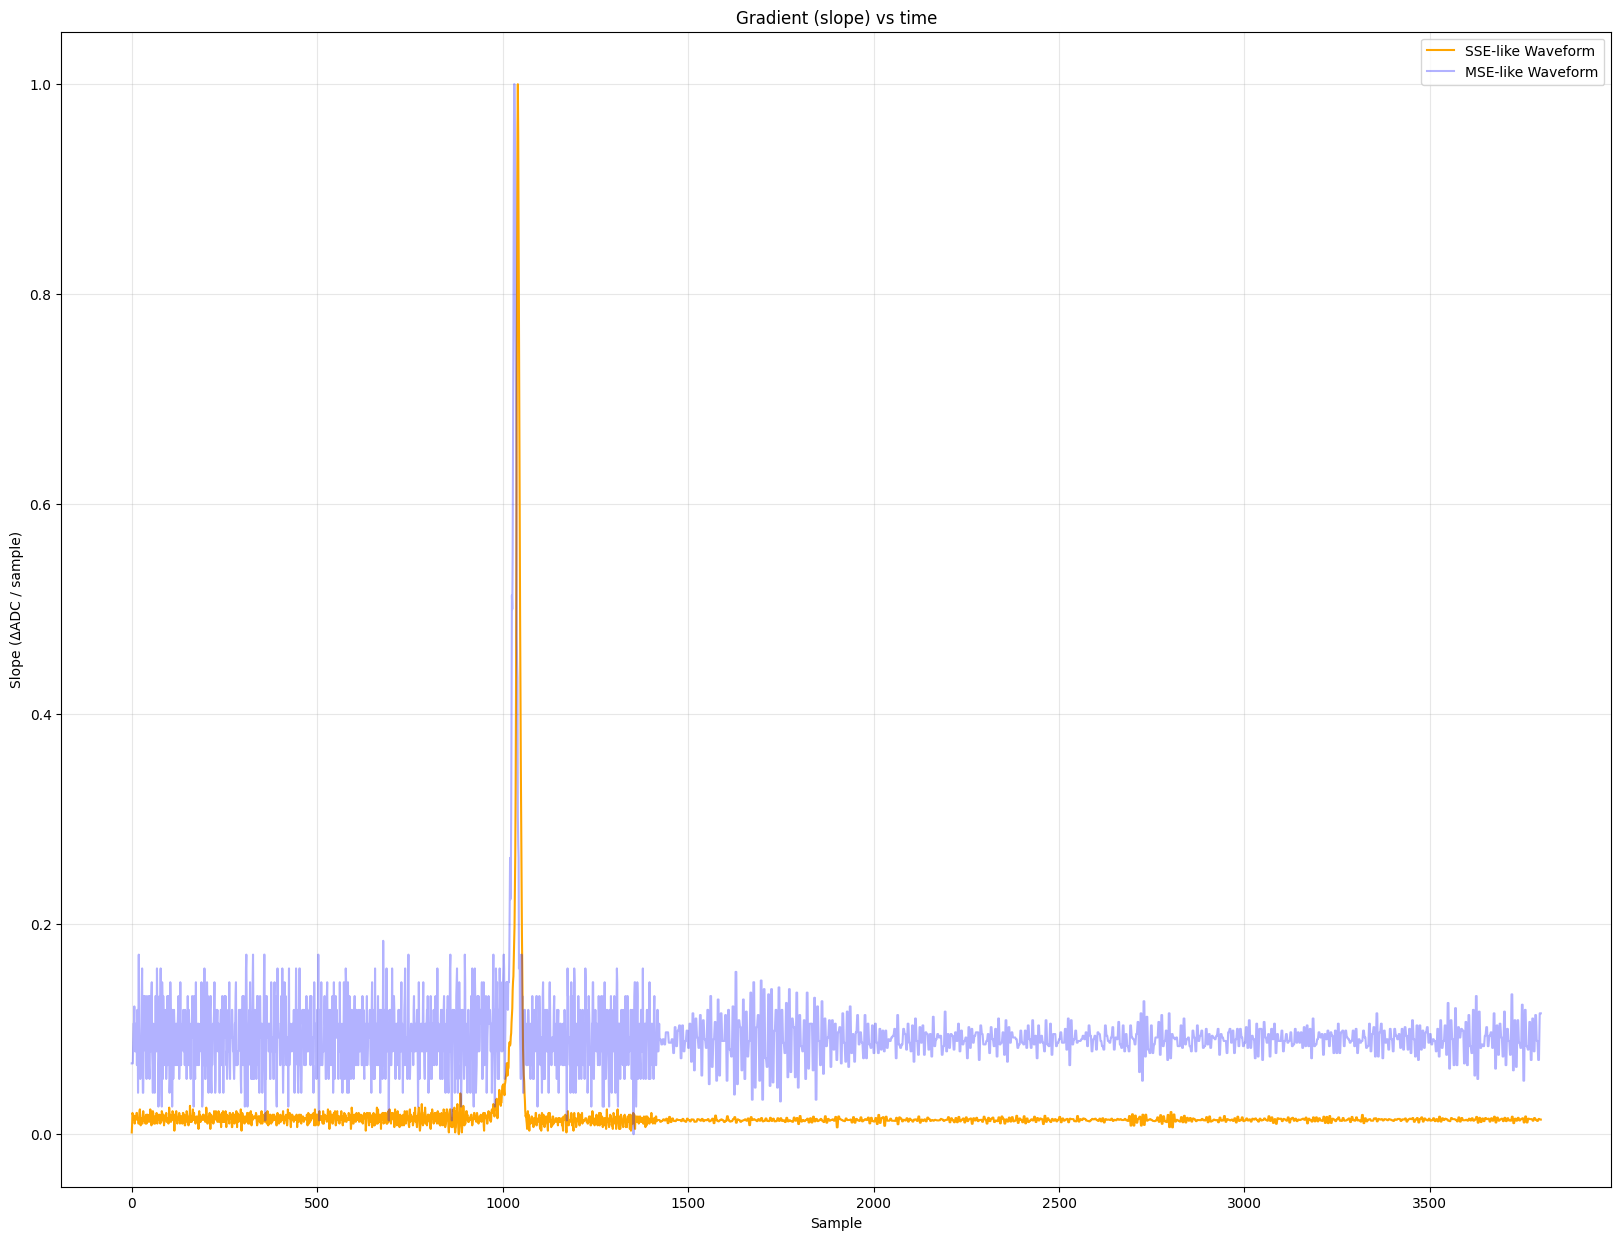

In [ ]:
# Single-Site Event (SSE): passes all PSD cuts
sse_indices = np.where(
    (psd_label_low_avse == 1) &
    (psd_label_high_avse == 1) &
    (psd_label_dcr == 1) &
    (psd_label_lq == 1)
)[0]

# Multi-Site Event (MSE): fails at least one PSD cut
mse_indices = np.where(
    (psd_label_low_avse == 0) |
    (psd_label_high_avse == 0) |
    (psd_label_dcr == 0) |
    (psd_label_lq == 0)
)[0]

# Choose one random index from each category
idx_sse = np.random.choice(sse_indices)
idx_mse = np.random.choice(mse_indices)

# Extract one sse and one mse waveform
wf_sse = raw_waveform[idx_sse]
wf_mse = raw_waveform[idx_mse]
time_index = np.arange(0, len(waveform))

# Compare transforms for the two waveforms (SSE vs MSE)
project_code.compare_transforms1(wf_sse, wf_mse, time_index)
project_code.compare_transforms2(wf_sse, wf_mse, time_index)